In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import keras
from keras import regularizers
from keras import initializers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, MaxPooling1D, Flatten, Embedding, Input
from keras.layers.convolutional import Conv1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from tensorboard.plugins.pr_curve import summary as pr_summary
import matplotlib.pyplot as plt

%matplotlib inline

/Users/tim/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Preprocessing

In [5]:
DATASET = 3  # Select dataset

Xs_data = ['neuron_params_d_I_samples_220K.csv', 
           'neuron_params_I_d_a_b_c_samples_110K.csv', 
           'neuron_params_I_d_a_b_samples_110K.csv', 
           'neuron_params_I_d_a_samples_110K.csv', 
           'neuron_params_I_samples_110K.csv']

ys_data = ['neuron_params_d_I_labels_220K.csv', 
           'neuron_params_I_d_a_b_c_labels_110K.csv', 
           'neuron_params_I_d_a_b_labels_110K.csv', 
           'neuron_params_I_d_a_labels_110K.csv', 
           'neuron_params_I_labels_110K.csv']

In [6]:
X = pd.read_csv('../../datasets/parametric_neuron_data/' + Xs_data[DATASET], index_col=0, header=None).T
y = pd.read_csv('../../datasets/parametric_neuron_data/' + ys_data[DATASET], index_col=0, header=None).T

In [7]:
# Add "header" as data
X.loc[-1] = X.columns
y.loc[-1] = y.columns

(num_samples, num_features) = X.shape

# Normalize input
X = X.apply(zscore)

# 80/20 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

# Add an extra dimension to  XX  for 1-D convolution.
X_train_cnn = np.expand_dims(X_train.as_matrix(), axis=2)
X_test_cnn = np.expand_dims(X_test.as_matrix(), axis=2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d658ed0>,
      dtype=object)

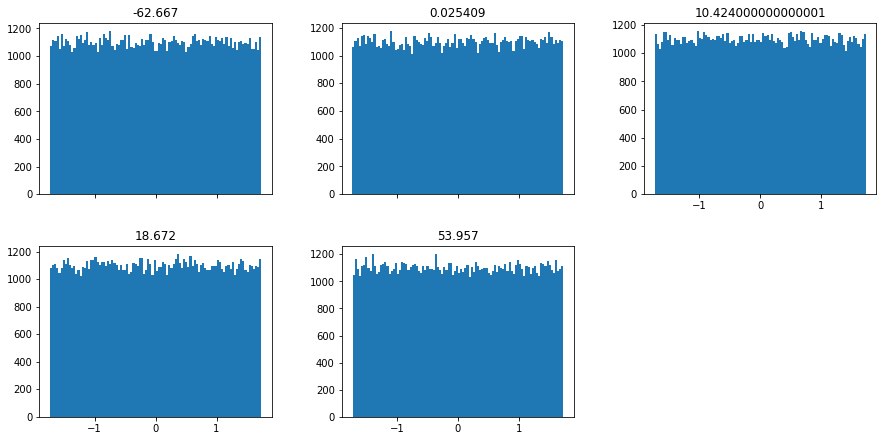

In [8]:
X.hist(grid=False, figsize=(15,40), layout=(10,3), bins=100, sharex=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f4daf90>]],
      dtype=object)

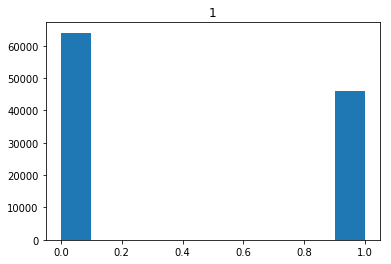

In [9]:
y.hist(grid=False)

# TensorBoard Visualization

Displays Precision-Recall curve for Keras models.

Adapted from: https://medium.com/@akionakas/precision-recall-curve-with-keras-cd92647685e1

In [10]:
class PRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        # One extra argument to indicate whether or not to use the PR curve summary.
        self.pr_curve = kwargs.pop('pr_curve', True)
        super(PRTensorBoard, self).__init__(*args, **kwargs)

        global tf
        import tensorflow as tf

    def set_model(self, model):
        super(PRTensorBoard, self).set_model(model)

        if self.pr_curve:
            # Get the prediction and label tensor placeholders.
            predictions = self.model._feed_outputs[0]
            labels = tf.cast(self.model._feed_targets[0], tf.bool)
            # Create the PR summary OP.
            self.pr_summary = pr_summary.op(name='pr_curve',
                                            predictions=predictions,
                                            labels=labels,
                                            display_name='Precision-Recall Curve')

    def on_epoch_end(self, epoch, logs=None):
        super(PRTensorBoard, self).on_epoch_end(epoch, logs)

        if self.pr_curve and self.validation_data:
            # Get the tensors again.
            tensors = self.model._feed_targets + self.model._feed_outputs
            # Predict the output.
            predictions = self.model.predict(self.validation_data[0])
            # Build the dictionary mapping the tensor to the data.
            val_data = [self.validation_data[1], predictions]
            feed_dict = dict(zip(tensors, val_data))
            # Run and add summary.
            result = self.sess.run([self.pr_summary], feed_dict=feed_dict)
            self.writer.add_summary(result[0], epoch)
        self.writer.flush()

# CNN Model

In [11]:
epochs = 10
batch_size = 32

## Dataset 0: neuron_params_d_I

In [ ]:
# Conv 4x3
inputs = Input(shape=(num_features, 1))
conv1 = Conv1D(4, 3, padding='same', strides=1)(inputs)
bn1 = BatchNormalization()(conv1)
relu1 = Activation('relu')(bn1)

# Conv 8x3
conv2 = Conv1D(8, 3, padding='same', strides=1)(relu1)
bn2 = BatchNormalization()(conv2)
relu2 = Activation('relu')(bn2)
flatten = Flatten()(relu2)

# FC 32
fc1 = Dense(32)(flatten)
bn3 = BatchNormalization()(fc1)
relu3 = Activation('relu')(bn3)

# FC 16
fc2 = Dense(16)(relu3)
bn4 = BatchNormalization()(fc2)
relu4 = Activation('relu')(bn4)

# FC 16
fc3 = Dense(16)(relu4)
bn5 = BatchNormalization()(fc3)
relu5 = Activation('relu')(bn5)

# Output
fc4 = Dense(1)(relu5)
outputs = Activation('sigmoid')(fc4)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [ ]:
model.fit(X_train_cnn, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=[X_test_cnn, y_test], # NOTE: must pass test data for PRTensorBoard callback
          shuffle=True,
          callbacks=[PRTensorBoard(log_dir='logs/adam_dropout-50_dataset-' + str(DATASET)), EarlyStopping(monitor='val_acc', patience=2)])

## Dataset 1: neuron_params_I_d_a_b_c

In [ ]:
# Conv 16x3
inputs = Input(shape=(num_features, 1))
conv1 = Conv1D(16, 3, padding='same', strides=1)(inputs)
bn1 = BatchNormalization()(conv1)
relu1 = Activation('relu')(bn1)

# Conv 32x3 convolutions
conv2 = Conv1D(32, 3, padding='same', strides=1)(relu1)
bn2 = BatchNormalization()(conv2)
relu2 = Activation('relu')(bn2)
flatten = Flatten()(relu2)

# FC 128
fc1 = Dense(128)(flatten)
bn3 = BatchNormalization()(fc1)
relu3 = Activation('relu')(bn3)
drop1 = Dropout(0.5)(relu3)

# FC 64
fc2 = Dense(64)(drop1)
bn4 = BatchNormalization()(fc2)
relu4 = Activation('relu')(bn4)
drop2 = Dropout(0.5)(relu4)

# FC 32
fc3 = Dense(32)(drop2)
bn5 = BatchNormalization()(fc3)
relu5 = Activation('relu')(bn5)
drop3 = Dropout(0.5)(relu5)

# Output
fc4 = Dense(1)(drop3)
outputs = Activation('sigmoid')(fc4)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
opt = keras.optimizers.RMSprop(lr=0.001)
model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [ ]:
model.fit(X_train_cnn, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=[X_test_cnn, y_test], # NOTE: must pass test data for PRTensorBoard callback
          shuffle=True,
          callbacks=[PRTensorBoard(log_dir='logs/adagrad_dropout-50_dataset-' + str(DATASET)), EarlyStopping(monitor='val_acc', patience=2)])

## Dataset 2: neuron_params_I_d_a_b

In [ ]:
# 16 3x16 convolutions
inputs = Input(shape=(num_features, 1))
conv1 = Conv1D(16, 3, padding='same', strides=1)(inputs)
bn1 = BatchNormalization()(conv1)
relu1 = Activation('relu')(bn1)

# 32 3x16 convolutions
conv2 = Conv1D(32, 3, padding='same', strides=1)(relu1)
bn2 = BatchNormalization()(conv2)
relu2 = Activation('relu')(bn2)
flatten = Flatten()(relu2)

# FC 512
fc1 = Dense(512)(flatten)
bn3 = BatchNormalization()(fc1)
relu3 = Activation('relu')(bn3)
drop1 = Dropout(0.75)(relu3)

# FC 256
fc2 = Dense(256)(drop1)
bn4 = BatchNormalization()(fc2)
relu4 = Activation('relu')(bn4)
drop2 = Dropout(0.5)(relu4)

# FC 128
fc3 = Dense(128)(drop2)
bn5 = BatchNormalization()(fc3)
relu5 = Activation('relu')(bn5)
drop3 = Dropout(0.5)(relu5)

# Output
fc4 = Dense(1)(drop3)
outputs = Activation('sigmoid')(fc4)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
opt = keras.optimizers.Adagrad()

model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [ ]:
model.fit(X_train_cnn, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=[X_test_cnn, y_test], # NOTE: must pass test data for PRTensorBoard callback
          shuffle=True,
          callbacks=[PRTensorBoard(log_dir='logs/nadam_dropout-50_dataset-' + str(DATASET)), EarlyStopping(monitor='val_acc', patience=2)])

## Dataset 3: neuron_params_I_d_a

In [15]:
# Conv 8x3
inputs = Input(shape=(num_features, 1))
conv1 = Conv1D(8, 3, padding='same', strides=1)(inputs)
bn1 = BatchNormalization()(conv1)
relu1 = Activation('relu')(bn1)
flatten = Flatten()(relu1)

# FC 32
fc1 = Dense(32)(flatten)
bn3 = BatchNormalization()(fc1)
relu3 = Activation('relu')(bn3)

# FC 16
fc2 = Dense(16)(relu3)
bn4 = BatchNormalization()(fc2)
relu4 = Activation('relu')(bn4)

# FC 16
fc3 = Dense(16)(relu4)
bn5 = BatchNormalization()(fc3)
relu5 = Activation('relu')(bn5)

# Output
fc4 = Dense(1)(relu5)
outputs = Activation('sigmoid')(fc4)

model = Model(inputs=inputs, outputs=outputs)

In [22]:
opt = keras.optimizers.Nadam()

model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [23]:
model.fit(X_train_cnn, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=[X_test_cnn, y_test], # NOTE: must pass test data for PRTensorBoard callback
          shuffle=True,
          callbacks=[PRTensorBoard(log_dir='logs/adam_dropout-50_dataset-' + str(DATASET)), EarlyStopping(monitor='val_acc', patience=2)])

Train on 88000 samples, validate on 22000 samples
Epoch 1/10
88000/88000 [==============================] - 16s 187us/step - loss: 0.0668 - acc: 0.9728 - val_loss: 0.0590 - val_acc: 0.9777
Epoch 2/10
88000/88000 [==============================] - 16s 179us/step - loss: 0.0648 - acc: 0.9735 - val_loss: 0.0579 - val_acc: 0.9779
Epoch 3/10
88000/88000 [==============================] - 16s 180us/step - loss: 0.0636 - acc: 0.9739 - val_loss: 0.0571 - val_acc: 0.9779
Epoch 4/10
88000/88000 [==============================] - 16s 180us/step - loss: 0.0636 - acc: 0.9737 - val_loss: 0.0573 - val_acc: 0.9777
Epoch 5/10
88000/88000 [==============================] - 16s 178us/step - loss: 0.0629 - acc: 0.9742 - val_loss: 0.0571 - val_acc: 0.9780
Epoch 6/10
88000/88000 [==============================] - 16s 181us/step - loss: 0.0617 - acc: 0.9744 - val_loss: 0.0569 - val_acc: 0.9776
Epoch 7/10
88000/88000 [==============================] - 16s 181us/step - loss: 0.0638 - acc: 0.9738 - val_loss: 0.

# Performance Scores

In [ ]:
results = [0.98625, 0.9728, 0.9757, 0.978, 0]
labels = ['d_I', 'I_d_a_b_c', 'I_d_a_b', 'I_d_a', 'I']